# Solution - Exercice 4 of TD 1

### Check your environment for troubleshooting if necessary

In [1]:
import gym
import numpy as np
import matplotlib as mplt
import sys

print("python : ", sys.version)
print("numpy :", np.__version__)
print("gym :", gym.__version__)
print("matplotlib :", mplt.__version__)

python :  3.7.4 (default, Aug 13 2019, 20:35:49) 
[GCC 7.3.0]
numpy : 1.19.1
gym : 0.15.6
matplotlib : 3.1.1


### Necessary imports

In [2]:
import gym
import gym.envs.toy_text.frozen_lake as fl
import numpy as np
import matplotlib.pyplot as plt
from utils import render_policy
np.set_printoptions(precision=3)

Using [discover.py](https://www.eleves.ens.fr/home/pesquere/MDP_X/discover.py), create the environement.

In [3]:
# Create environment
# is_slippery=True makes the transition random 
# (even if you select a direction you might slip and take 
# a random direction of stay in place instead).
# is_slippery=False makes the transition deterministic
# (e.g if you choose to go right, you wll go right with proba 100%).
env = gym.make('FrozenLake-v0', is_slippery=True)

def to_s(row,col):
    return row*env.ncol + col

def to_row_col(s):
    col = s % env.ncol
    row = s // env.ncol
    return row, col

NBR_EPISODES = 2000
HORIZON = 200
GAMMA = 0.9

## Question 3

In [4]:
##### Question 3 #####
print("\n##### Question 3 #####\n")

VALUE_START = np.zeros(NBR_EPISODES)
for i in range(NBR_EPISODES):
    env.reset()
    done = False
    t = 0
    discount = 1
    while (not done) and (t < HORIZON):
        t += 1
        discount *= GAMMA
        next_state, r, done, _ = env.step(fl.RIGHT)
        VALUE_START[i] += discount * r

print(f"Monte Carlo estimation of the Value at starting point: \
{np.mean(VALUE_START):.3f}")


##### Question 3 #####

Monte Carlo estimation of the Value at starting point: 0.012


In [5]:
offset = 10

plt.figure()
plt.title("Convergence of the Monte Carlo estimation\nof the value of the \
starting point")
plt.plot((np.cumsum(VALUE_START)/(np.arange(NBR_EPISODES)+1))[offset:])
plt.show()

In [6]:
pi = np.ones((env.nS), dtype='int') * fl.RIGHT
render_policy(env, pi)


SFFF
FHFH
FFFH
HFFG


  (Right)
SFFF
FHFH
FFFH
HFFG


  (Right)
SFFF
FHFH
FFFH
HFFG


  (Right)
SFFF
FHFH
FFFH
HFFG


  (Right)
SFFF
FHFH
FFFH
HFFG



/$$$$$$$$                        /$$                       /$$
|__  $$__/                       | $$                      | $$
   | $$  /$$$$$$   /$$$$$$       | $$$$$$$   /$$$$$$   /$$$$$$$
   | $$ /$$__  $$ /$$__  $$      | $$__  $$ |____  $$ /$$__  $$
   | $$| $$  \ $$| $$  \ $$      | $$  \ $$  /$$$$$$$| $$  | $$
   | $$| $$  | $$| $$  | $$      | $$  | $$ /$$__  $$| $$  | $$
   | $$|  $$$$$$/|  $$$$$$/      | $$$$$$$/|  $$$$$$$|  $$$$$$$
   |__/ \______/  \______/       |_______/  \_______/ \_______/
        


## Question 4

In [7]:
##### Question 4 #####
print("\n##### Question 4 #####\n")

def value_function(pi):
    """
    pi : int array
    For each index i, pi[i] is the action (int) chosen in state i

    return:
    ------
    V_pi : float array
    For each index i, V_pi[i] is the value (float) of the state i
    """
    # Compute both the reward vector r_pi and
    # transition matrix P_pi associated to the policy on the given env
    r_pi = np.zeros((env.nS))
    P_pi = np.zeros((env.nS, env.nS))
    for state in range(env.nS):
        transitions_info = env.P[state][pi[state]]
        for transition in transitions_info:
            proba = transition[0]
            next_state = transition[1]
            reward = transition[2]
            P_pi[state,next_state] += proba
            r_pi[state] += reward*proba
    # Compute the value function of the policy pi
    Id = np.eye(env.nS)
    return np.linalg.inv(Id - GAMMA*P_pi) @ r_pi

simple_pi = fl.RIGHT*np.ones((env.nS))

V_simple_pi = value_function(simple_pi)
print(f"Value function of the always RIGHT policy:\n{V_simple_pi}")
print(f"Value estimate of the starting point: {V_simple_pi[0]:.3f}")


##### Question 4 #####

Value function of the always RIGHT policy:
[1.308e-02 1.176e-02 2.744e-02 1.153e-16 1.875e-02 1.098e-16 6.402e-02
 1.537e-16 4.944e-02 1.460e-01 1.860e-01 0.000e+00 0.000e+00 3.008e-01
 5.559e-01 0.000e+00]
Value estimate of the starting point: 0.013


## Question 5

In [8]:
##### Question 5 #####
print("\n##### Question 5 #####\n")

def value_function_2(pi, epsilon, max_iter):
    """
    pi : int array
    For each index i, pi[i] is the action (int) chosen in state i

    epsilon : float
    Used as a threshold for the stopping rule

    max_iter : int
    Hard threshold on the number of loops

    return:
    ------
    V_pi : float array
    For each index i, V_pi[i] is the value (float) of the state i
    """
    # Compute both the reward vector r_pi and
    # transition matrix P_pi associated to the policy on the given env
    r_pi = np.zeros((env.nS))
    P_pi = np.zeros((env.nS, env.nS))
    for state in range(env.nS):
        transitions_info = env.P[state][pi[state]]
        for transition in transitions_info:
            proba = transition[0]
            next_state = transition[1]
            reward = transition[2]
            P_pi[state,next_state] += proba
            r_pi[state] += reward*proba
    # Compute the value function V_pi of the policy pi
    V_pi = np.zeros((env.nS))
    V_pi_old = np.zeros((env.nS))
    delta_linf = np.zeros((max_iter))
    stop = False
    i = 0
    while (not stop) and (i < max_iter):
        V_pi = r_pi + GAMMA * (P_pi @ V_pi_old)
        delta_linf[i] = np.max(np.abs(V_pi-V_pi_old))
        V_pi_old[:] = V_pi
        if delta_linf[i]<epsilon:
            stop = True
            delta_linf = delta_linf[:i+1]
        i += 1
    return V_pi, delta_linf

V_simple_pi, delta_linf = value_function_2(simple_pi, 1e-4, 10000)
print(f"Value function of the always RIGHT policy:\n{V_simple_pi}")
plt.figure()
plt.title("Semi-log graph of the infinity norm of difference between \
two iterates\nThe Linearity of this graph proves exponential convergence")
plt.semilogy(delta_linf)
plt.show()
print("Number of iterations:", delta_linf.size)
print("Last residual", delta_linf[-1])


##### Question 5 #####

Value function of the always RIGHT policy:
[0.013 0.012 0.027 0.    0.019 0.    0.064 0.    0.049 0.146 0.186 0.
 0.    0.301 0.556 0.   ]


Number of iterations: 17
Last residual 7.988610483180246e-05


## Question 6


##### Question 6 #####

Optimal value function:
[0.068 0.061 0.074 0.055 0.091 0.    0.112 0.    0.145 0.247 0.299 0.
 0.    0.38  0.639 0.   ]


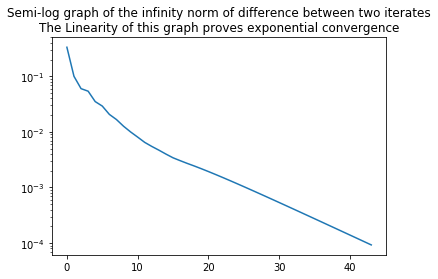

Number of iterations: 44
Last residual 9.272422715012052e-05


In [9]:
##### Question 6 #####
print("\n##### Question 6 #####\n")

def value_function_optimal(epsilon, max_iter):
    """
    epsilon : float
    Used as a threshold for the stopping rule

    max_iter : int
    Hard threshold on the number of loops

    returns:
    -------
    V_opt : float array, (env.nS,) size
    Optimal value function on the FrozenLake MDP given a discount GAMMA
    V_opt[state index] = Value of that state
    """
    V_opt_old = np.zeros((env.nS))
    V_opt = np.zeros((env.nS))
    delta_linf = np.zeros((max_iter))
    i = 0
    stop = False
    while (not stop) and (i < max_iter):
        for state in range(env.nS):
            # Q is the local (slice) state-action value function for 'state'
            Q = np.zeros((env.nA))
            for action in range(env.nA):
                transitions_info = env.P[state][action]
                for transition in transitions_info:
                    proba  = transition[0]
                    next_state = transition[1]
                    reward  = transition[2]
                    Q[action] += proba*(reward + GAMMA*V_opt_old[next_state])
            V_opt[state] = np.max(Q)
        delta_linf[i] = np.max(np.abs(V_opt_old-V_opt))
        np.copyto(V_opt_old, V_opt)
        if delta_linf[i] < epsilon:
            delta_linf = delta_linf[:i+1]
            stop = True
        i += 1
    return V_opt, delta_linf

V_opt, delta_linf = value_function_optimal(1e-4, 10000)
print(f"Optimal value function:\n{V_opt}")
plt.figure()
plt.title("Semi-log graph of the infinity norm of difference between \
two iterates\nThe Linearity of this graph proves exponential convergence")
plt.semilogy(delta_linf)
plt.show()
print("Number of iterations:", delta_linf.size)
print("Last residual", delta_linf[-1])

## Question 7

In [10]:
##### Question 7 #####
print("\n##### Question 7 #####\n")

def value_iteration(epsilon, max_iter):
    """
    epsilon : float
    Used as a threshold for the stopping rule

    max_iter : int
    Hard threshold on the number of loops

    returns:
    -------
    pi : int array, size (env.nS,)
    An optimal policy
    """
    # Compute the optimal value function
    V_opt, _ = value_function_optimal(epsilon, max_iter)

    # Compute the state-action value function in order to
    # select the/a greedy action in each state.
    Q = np.zeros((env.nS, env.nA))
    for state in range(env.nS):
        for action in range(env.nA):
            transitions_info = env.P[state][action]
            for transition in transitions_info:
                proba  = transition[0]
                next_state = transition[1]
                reward  = transition[2]
                Q[state, action] += proba*(reward + GAMMA*V_opt[next_state])

    # Go greedy in the action selection
    # 'np.argmax' breaks ties by selecting the minimal index in the array
    pi_opt = np.argmax(Q, axis=1)
    return pi_opt

def print_policy(pi):
    for row in range(env.nrow):
        for col in range(env.ncol):
            print(pi[to_s(row,col)], end='')
        print("")

print(f"Actions index: RIGHT: {fl.RIGHT} - LEFT: {fl.LEFT}")
print(f"               UP: {fl.UP}    - DOWN: {fl.DOWN}")
pi_opt = value_iteration(1e-4, 1000)
print("\nAn optimal policy is:\n")
print_policy(pi_opt)


##### Question 7 #####

Actions index: RIGHT: 2 - LEFT: 0
               UP: 3    - DOWN: 1

An optimal policy is:

0303
0000
3100
0210


## Question 8

In [11]:
##### Question 8 #####
print("\n##### Question 8 #####\n")

# The danger of Policy Iteration lies in the stopping criterion
# If not careful, one might end up with an algorithm that does not
# terminate and oscillates between optimal policies
# Even if it is computationally more expensive, we sometimes rather
# compare value functions of the policies than policies from one iterate
# to another.

# An easy improvement on the following code would be to use
# a warm start for policy evaluation steps (if iteration methods is used)
# That is to say, using the previously computed value function
# as the first step for the next policy evaluation

def policy_improvement(V):
    """
    V : float array, size (env.nS,)
    Value function of a policy

    returns:
    -------
    pi : int array, size (env.nS,)
    A policy that is greedy with respect to V
    """
    # Compute state-value function associated to V
    Q = np.zeros((env.nS, env.nA))
    for state in range(env.nS):
        for action in range(env.nA):
            transitions_info = env.P[state][action]
            for transition in transitions_info:
                proba  = transition[0]
                next_state = transition[1]
                reward  = transition[2]
                Q[state, action] += proba*(reward + GAMMA*V[next_state])
    # Compute the/a greedy policy with respect to the Q/V value function
    pi = np.argmax(Q, axis=1)
    return pi

def policy_iteration(epsilon, max_iter):
    """
    epsilon : float
    Used as a threshold for the stopping rule

    max_iter : int
    Hard threshold on the number of loops

    returns:
    -------
    pi : int array, size (env.nS,)
    An optimal policy
    """
    pi = np.zeros((env.nS))
    pi_old = np.zeros((env.nS))
    V_pi = np.zeros((env.nS))
    stop = False
    i = 0
    while (not stop) and (i < max_iter):
        pi_old = np.copy(pi)
        V_pi_old = np.copy(V_pi)

        # policy evaluation
        V_pi = value_function(pi) # test value_function_2 too !

        # policy improvement
        pi = policy_improvement(V_pi)

        i += 1
        stop = np.array_equal(pi, pi_old)
        # or, other criterion
        # stop = np.max(np.abs(V_pi - V_pi_old)) < epsilon
    return pi

print("\n")
print(f"Actions index: RIGHT: {fl.RIGHT} - LEFT: {fl.LEFT}")
print(f"               UP: {fl.UP}    - DOWN: {fl.DOWN}")
pi_opt = policy_iteration(1e-4, 1000)
print("\nAn optimal policy is:\n")
print_policy(pi_opt)


##### Question 8 #####



Actions index: RIGHT: 2 - LEFT: 0
               UP: 3    - DOWN: 1

An optimal policy is:

0303
0000
3100
0210


## Question 9

In [12]:
##### Question 9 #####
print("\n##### Question 9 #####\n")

# Try first with is_slippery=False to make it easier
# for Q-learning to learn a good policy.
# Try with is_slippery=True then : chances are 
# you will need more episodes to learn a good policy.
env = gym.make('FrozenLake-v0', is_slippery=False)

def Q_learning(n_episodes, 
               learning_rate, 
               epsilon_greedy, 
               epsilon_greedy_decay_freq, 
               epsilon_greedy_decay_factor, 
               ):
    """
    n_episodes : int
    Number of episodes (starting from state 'S' and ending either when
        goal is reached or when falling down a hole).
    
    learning_rate : float
    Constant learning rate for the TD step.

    epsilon_greedy : float
    Initial probability of random exploration.
    
    epsilon_greedy_freq : int
    Decrease epsilon_greedy every epsilon_greedy_decay episodes.
    
    epsilon_greedy_factor : float
    Decrease epsilon_greedy by (1-epsilon_greedy_factor)%.

    returns:
    -------
    Q_opt : float array, (env.nS, env.nA) size
    Optimal state-action value function on the FrozenLake MDP
    given a discount GAMMA
    Q_opt[state index][action index] = state-action value of that state
    """
    from tqdm import tqdm_notebook as tqdm

    Q_opt = np.zeros((env.nS, env.nA))

    for episode in tqdm(range(n_episodes)):
        done = False
        state = env.reset()

        if (episode + 1) % epsilon_greedy_decay_freq == 0:
            epsilon_greedy *= epsilon_greedy_decay_factor
        while not done:
            # epsilon-greedy exploration 
            if np.random.rand() < epsilon_greedy:
                action = env.action_space.sample()
            else:
                action = np.argmax(Q_opt[state, :])

            next_state, r, done, _ = env.step(action)
            pred = Q_opt[state, action]
            target = r + GAMMA * np.max(Q_opt[next_state, :])
            Q_opt[state][action] = Q_opt[state][action] + learning_rate * (target - pred)

            # Move on to next state
            state = next_state
    return Q_opt

n_episodes = 5000
learning_rate = 0.001
epsilon_greedy = 0.5
epsilon_greedy_decay_freq = 500
epsilon_greedy_decay_factor = 0.9

Q_opt_Q_learning = Q_learning(
    n_episodes,
    learning_rate,
    epsilon_greedy,
    epsilon_greedy_decay_freq,
    epsilon_greedy_decay_factor,
)

V_opt_Q_learning = np.max(Q_opt_Q_learning, axis=1)
pi_opt_Q_learning = np.argmax(Q_opt_Q_learning, axis=1)

V_opt, _ = value_function_optimal(1e-4, 1000)
pi_opt = policy_iteration(1e-4, 1000)

print(f"Q-learning value function:\n{V_opt_Q_learning}\n")
print(f"Difference with optimal value function:\n{V_opt - V_opt_Q_learning}\n")

print(f"Q-learning policy:\n{pi_opt_Q_learning}\n")
print(f"Optimal policy (policy iteration):\n{pi_opt}\n")

print('Game played by Q-learning')
render_policy(env, pi_opt_Q_learning)

print('\nGame played by an optimal policy')
render_policy(env, pi_opt)


##### Question 9 #####




Q-learning value function:
[9.968e-02 5.011e-03 5.488e-05 4.503e-08 1.836e-01 0.000e+00 6.610e-03
 0.000e+00 3.185e-01 5.095e-01 2.702e-01 0.000e+00 0.000e+00 7.436e-01
 9.579e-01 0.000e+00]

Difference with optimal value function:
[0.491 0.651 0.729 0.656 0.472 0.    0.803 0.    0.411 0.3   0.63  0.
 0.    0.156 0.042 0.   ]

Q-learning policy:
[1 0 1 0 1 0 1 0 2 1 1 0 0 2 2 0]

Optimal policy (policy iteration):
[1 2 1 0 1 0 1 0 2 1 1 0 0 2 2 0]

Game played by Q-learning

SFFF
FHFH
FFFH
HFFG


  (Down)
SFFF
FHFH
FFFH
HFFG


  (Down)
SFFF
FHFH
FFFH
HFFG


  (Right)
SFFF
FHFH
FFFH
HFFG


  (Down)
SFFF
FHFH
FFFH
HFFG


  (Right)
SFFF
FHFH
FFFH
HFFG


  (Right)
SFFF
FHFH
FFFH
HFFG



/$$    /$$ /$$             /$$
| $$   | $$|__/            | $$
| $$   | $$ /$$  /$$$$$$$ /$$$$$$    /$$$$$$   /$$$$$$  /$$   /$$
|  $$ / $$/| $$ /$$_____/|_  $$_/   /$$__  $$ /$$__  $$| $$  | $$
 \  $$ $$/ | $$| $$        | $$    | $$  \ $$| $$  \__/| $$  | $$
  \  $$$/  | $$| $$        | $$ /$$| $$  | $$|